In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
from datetime import datetime
from scipy.stats import poisson
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 

from tqdm import tqdm
import os
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) # Silence Prophet if nothing major happens


In [3]:
def height_to_unixepoch(height: int) -> int:
    return height * 30 + 1598306400

def height_to_timestamp(height: int) -> datetime:
    return datetime.fromtimestamp(height_to_unixepoch(height))

def unixepoch_to_height(timestamp):
    return (timestamp - 1598306400)/30

def datetime_to_height(year:int, month:int, day:int) -> float:
    dd = int(datetime(year, month, day).strftime('%s'))
    return int((dd - 1598306400)/30)

# Some overheads to suppress Prophet output
# https://github.com/facebook/prophet/issues/223#issuecomment-326455744
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        for fd in self.null_fds + self.save_fds:
            os.close(fd)    


def predict_on_dataframe(df, column_name = 'raw_bytes_network_power', n_days=450):
    dc = df[['datetime', column_name]].reset_index(drop=True)
    dc.columns = ['ds', 'y']
    
    m = Prophet(daily_seasonality=False)
    with suppress_stdout_stderr():
        m.fit(dc)
    future = m.make_future_dataframe(periods=n_days)
    fcst = m.predict(future)
    return fcst


### Circulating supply prediction

This is a parameter-free prediction of circulating supply, as an alternative to Starboard's [calculator](https://observablehq.com/@starboard/filecoin-circulating-supply-simulation) which requires user input about network trajectory.

There are several components of the circulating supply:
* FIL mined
* FIL locked
* FIL burned
* FIL vested - release of FIL token to investors
* FIL disbursed from mining reserve - a constant number (about 17 million FIL per day)

This calculator simulates the first three components with a black box time series predictor, Facebook Prophet, while the remaining two components are known preciselyy. 

In [13]:
YEARS_TO_PREDICT = 15

# predict the vesting policy
df_reward = pd.DataFrame(np.arange(14888, 14888+2880*365*YEARS_TO_PREDICT), columns=['height'])
df_reward['vested'] = 0
df_reward['vested'].iloc[0] += 10632000
df_reward['vested'].iloc[0:np.min([183*2880, len(df_reward)])] += np.ones(np.min([183*2880, len(df_reward)])) * (19015887 + 32787700) / 183/2880
df_reward['vested'].iloc[0:np.min([1*365*2880, len(df_reward)])] += np.ones(np.min([365*2880, len(df_reward)])) * (22421712 + 9400000) / 365/2880
df_reward['vested'].iloc[0:np.min([2*365*2880, len(df_reward)])] += np.ones(np.min([2*365*2880, len(df_reward)])) * (7223364) / 365/2/2880
df_reward['vested'].iloc[0:np.min([3*365*2880, len(df_reward)])] += np.ones(np.min([3*365*2880, len(df_reward)])) * (87637883 + 898958) / 365/3/2880
df_reward['vested'].iloc[0:np.min([6*365*2880, len(df_reward)])] += np.ones(np.min([6*365*2880, len(df_reward)])) * (400000000 + 9805053) / 365/3/2880
df_reward['vested'] = df_reward['vested'].cumsum()
df_reward['datetime'] = df_reward['height'].apply(height_to_timestamp).dt.date
df_reward = df_reward.groupby('datetime').mean()['vested'].reset_index()
df_reward['datetime'] = df_reward['datetime'].astype('datetime64[ns]')

data_cs = pd.read_csv('FIL_Protocol_Circulating_Supply.csv')
data_cs = data_cs.rename(columns={'stateTime': 'datetime'})
data_cs_mined = predict_on_dataframe(data_cs, 'Total FIL Mined', n_days=365*YEARS_TO_PREDICT)
data_cs_locked = predict_on_dataframe(data_cs, 'Total FIL Burned', n_days=365*YEARS_TO_PREDICT)
data_cs_burned = predict_on_dataframe(data_cs, 'Total FIL Locked', n_days=365*YEARS_TO_PREDICT)
locked_df = data_cs_locked[['ds', 'yhat']]
locked_df.columns = ['datetime', 'locked']
locked_df['locked'] *= 1e6
burned_df = data_cs_burned[['ds', 'yhat']]
burned_df.columns = ['datetime', 'burned']
burned_df['burned'] *= 1e6
mined_df = data_cs_mined[['ds', 'yhat']]
mined_df.columns = ['datetime', 'mined']
mined_df['mined'] *= 1e6


13:31:16 - cmdstanpy - INFO - Chain [1] start processing
13:31:17 - cmdstanpy - INFO - Chain [1] done processing
13:31:18 - cmdstanpy - INFO - Chain [1] start processing
13:31:19 - cmdstanpy - INFO - Chain [1] done processing
13:31:20 - cmdstanpy - INFO - Chain [1] start processing
13:31:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/lp/k8hnm7l54kzcj3_6zp0z8d4m0000gn/T/ipykernel_15989/3607765268.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locked_df['locked'] *= 1e6
/var/folders/lp/k8hnm7l54kzcj3_6zp0z8d4m0000gn/T/ipykernel_15989/3607765268.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [14]:
df_alt = pd.merge(mined_df, locked_df)
df_alt = pd.merge(df_alt, burned_df)
df_alt = pd.merge(df_alt, df_reward)
df_alt['disbursed'] = 17066618.9617734
df_alt.index = df_alt.datetime
df_alt = df_alt[df_alt.columns[1:]]

Text(0, 0.5, 'Circulating supply (mil FIL)')

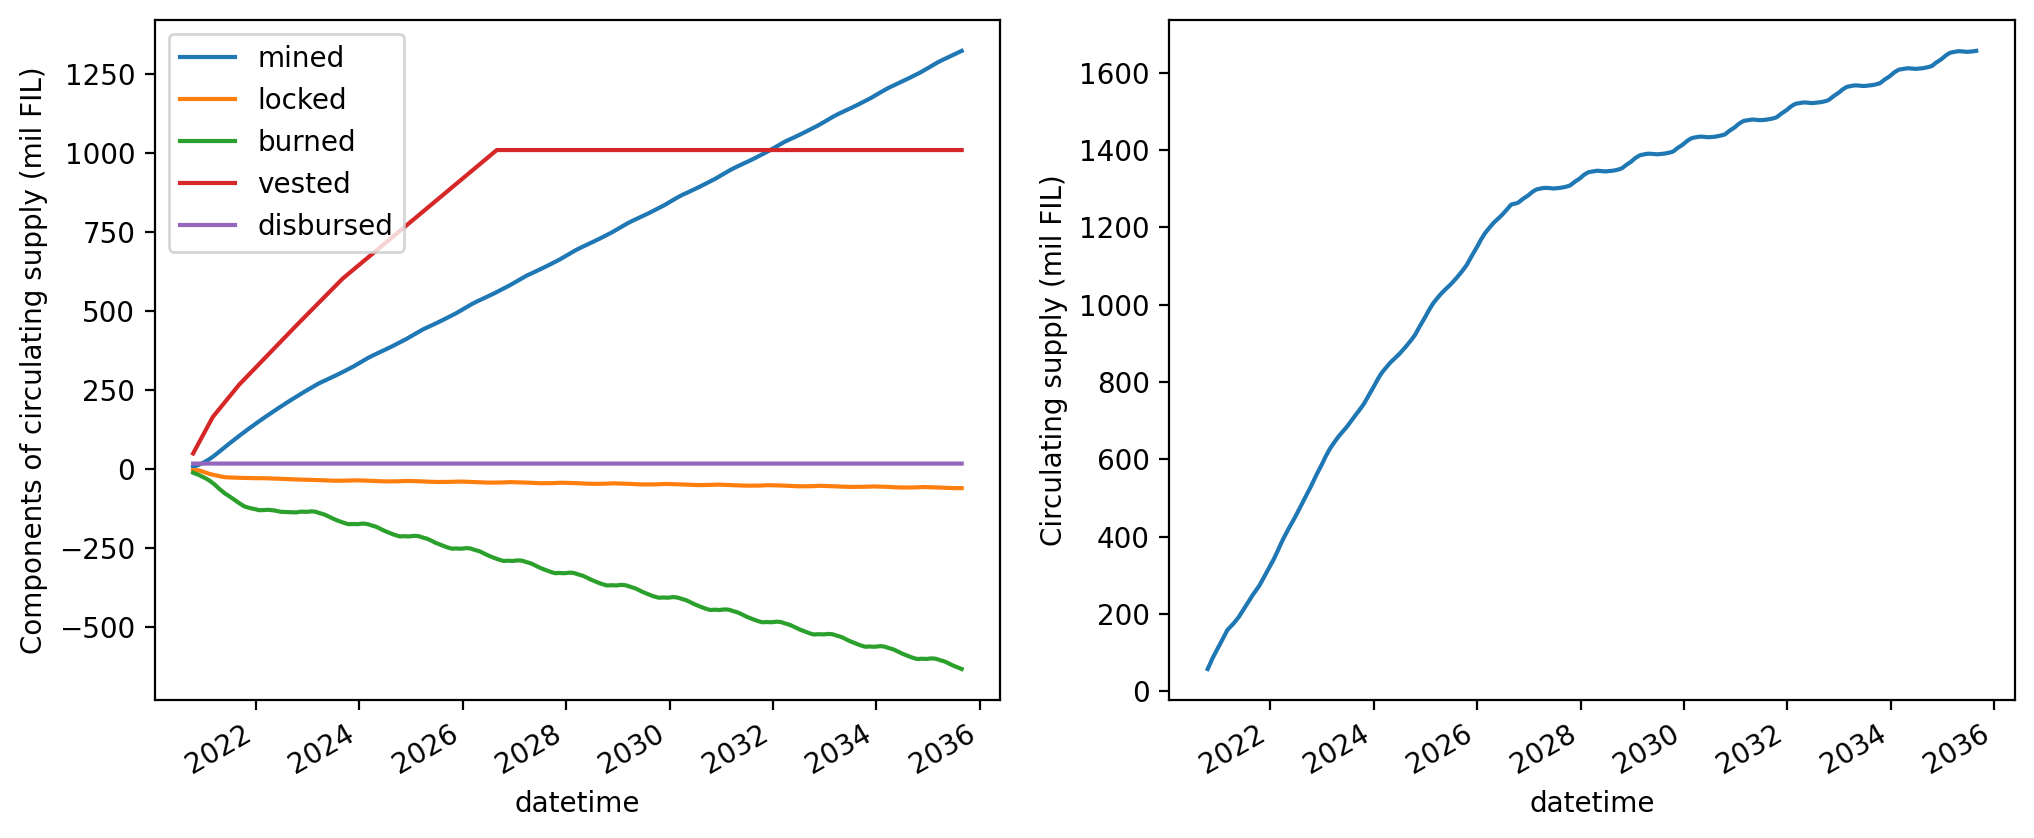

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
(df_alt/1e6).plot(ax=ax1)
(df_alt.sum(axis=1)/1e6).plot(ax=ax2)
ax1.set_ylabel('Components of circulating supply (mil FIL)')
ax2.set_ylabel('Circulating supply (mil FIL)')